# Network Analysis

Quick sanity checks and plots of a solved PyPSA-Earth network.

## Sync a solved network (from repo root)

```bash
rsync -avz --progress \
  engs2523@arc-login.arc.ox.ac.uk:/data/engs-df-green-ammonia/engs2523/pypsa-earth/results/<run-name>/networks/<network-file>.nc \
  results/arc/<local-name>/networks/
```
Then update `RESULT_PATH` in the next cell to point at the downloaded file.

In [37]:
# Download natura raster on first run
import cartopy; from cartopy import feature as cf
cf.NaturalEarthFeature("physical","land","10m")

In [38]:
from pathlib import Path

# Solved network file path (absolute)
RESULT_PATH = Path('/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/results/arc/europe-day-70n-core-fixed/networks/elec_s_70_ec_lcopt_Co2L-3h.nc')

if not RESULT_PATH.exists():
    raise FileNotFoundError(
        f"Solved network missing at {RESULT_PATH}. Update RESULT_PATH or sync the file first."
    )
print('Using network file:', RESULT_PATH.resolve())

Using network file: /Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/results/arc/europe-day-70n-core-fixed/networks/elec_s_70_ec_lcopt_Co2L-3h.nc


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import pypsa
except ImportError as exc:
    raise SystemExit('PyPSA missing. Install via mamba install -c conda-forge pypsa') from exc

try:
    import cartopy  # noqa: F401
    CARTOPY_AVAILABLE = True
except Exception:
    CARTOPY_AVAILABLE = False

print('PyPSA version:', pypsa.__version__)
print('Cartopy available:', CARTOPY_AVAILABLE)

PyPSA version: 0.28.0
Cartopy available: True


In [40]:
n = pypsa.Network(str(RESULT_PATH))
print(n)
print('Snapshots:', list(n.snapshots))
print('Buses:', len(n.buses), 'Lines:', len(n.lines), 'Generators:', len(n.generators))

       'CZ0 0 lignite', 'DE0 0 coal', 'DE0 0 geothermal', 'DE0 0 lignite',
       'DE0 0 oil', 'DE27 0 coal', 'DK0 0 biomass', 'DK0 0 coal', 'DK0 0 oil',
       'DK12 0 coal', 'DK12 0 oil', 'ES0 0 biomass', 'ES0 0 coal',
       'ES0 0 lignite', 'ES0 0 oil', 'ES9 0 coal', 'ES9 0 lignite',
       'ES9 0 oil', 'FR0 0 coal', 'FR0 0 geothermal', 'FR0 0 lignite',
       'FR0 0 oil', 'FR7 0 biomass', 'FR7 0 coal', 'FR7 0 oil',
       'GB3 0 biomass', 'GB3 0 coal', 'GB3 0 oil', 'GB32 0 biomass',
       'GB32 0 oil', 'GB4 0 biomass', 'GR0 0 coal', 'GR0 0 lignite',
       'GR0 0 oil', 'GR11 0 oil', 'GR40 0 oil', 'HU0 0 geothermal',
       'HU0 0 lignite', 'HU0 0 oil', 'IT0 0 coal', 'IT0 0 geothermal',
       'IT0 0 oil', 'IT6 0 coal', 'IT6 0 oil', 'PL0 0 biomass', 'PL0 0 coal',
       'PL0 0 lignite', 'PL0 0 oil', 'PT0 0 biomass', 'PT0 0 coal',
       'PT0 0 oil', 'PT47 0 oil', 'RO0 0 coal', 'RO0 0 lignite', 'RO0 0 oil',
       'RS0 0 lignite', 'RS0 0 oil', 'SE12 0 biomass', 'SE12 0 oil',
      

PyPSA Network
Components:
 - Bus: 210
 - Carrier: 25
 - Generator: 410
 - GlobalConstraint: 1
 - Line: 20
 - Link: 362
 - Load: 49
 - StorageUnit: 15
 - Store: 70
Snapshots: 8
Snapshots: [Timestamp('2013-01-01 00:00:00'), Timestamp('2013-01-01 03:00:00'), Timestamp('2013-01-01 06:00:00'), Timestamp('2013-01-01 09:00:00'), Timestamp('2013-01-01 12:00:00'), Timestamp('2013-01-01 15:00:00'), Timestamp('2013-01-01 18:00:00'), Timestamp('2013-01-01 21:00:00')]
Buses: 210 Lines: 20 Generators: 410


## Installed capacities (MW)

In [41]:
cap_by_carrier = n.generators.groupby('carrier')['p_nom'].sum().sort_values(ascending=False)
cap_df = cap_by_carrier.to_frame(name='p_nom_MW')
cap_df

,p_nom_MW
carrier,
load shedding,498406.971264
solar,221678.584067
onwind,188916.315791
CCGT,167746.088572
nuclear,109630.518175
ror,32542.295985
offwind-dc,25911.065676
offwind-ac,0.000000


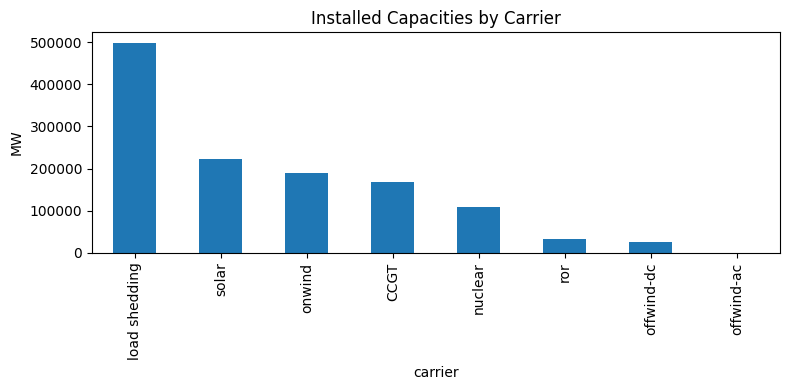

In [42]:
ax = cap_by_carrier.plot(kind='bar', figsize=(8, 4), title='Installed Capacities by Carrier')
ax.set_ylabel('MW')
plt.tight_layout()
plt.show()

## Generation mix (snapshot 0)

In [43]:
snap = n.snapshots[0]
tech_mix = n.generators_t.p.loc[snap].groupby(n.generators['carrier']).sum().sort_values(ascending=False)
tech_mix

carrier
onwind           261017.212227
offwind-dc        11814.380746
ror               10615.963757
nuclear            2381.871831
CCGT                534.684310
load shedding       385.825621
offwind-ac            0.000000
solar                 0.000000
Name: 2013-01-01 00:00:00, dtype: float64

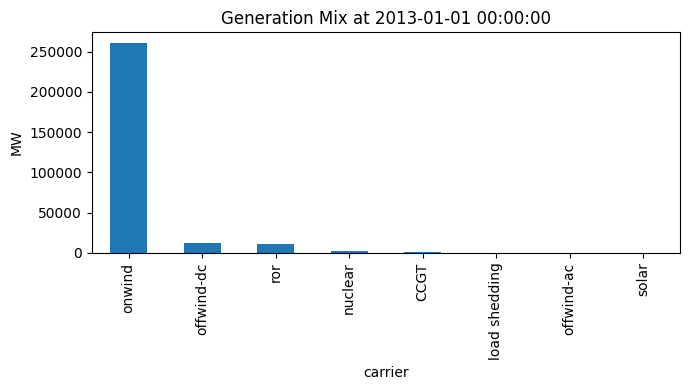

In [44]:
tech_mix.plot(kind='bar', figsize=(7, 4), title=f'Generation Mix at {snap}')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

## Simple network map

/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


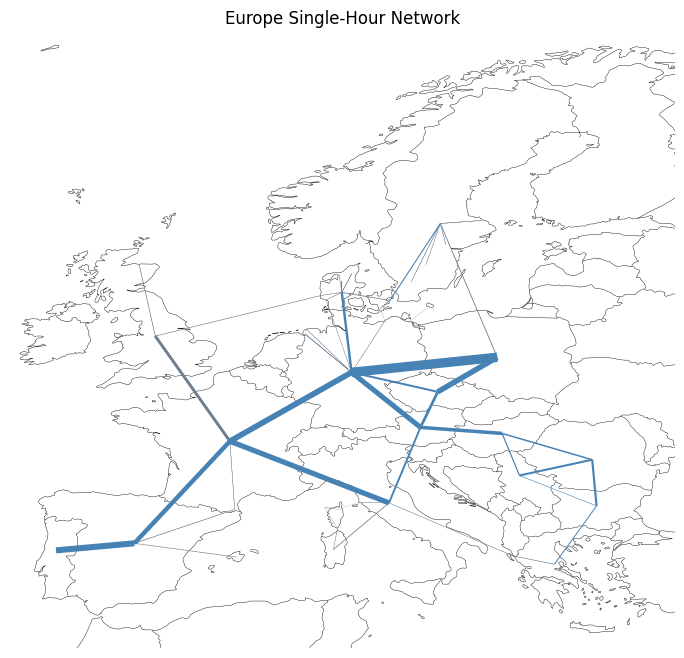

In [45]:
if CARTOPY_AVAILABLE:
    try:
        import cartopy.crs as ccrs
        plt.close("all")  # avoid reusing stale GeoAxes when re-running the cell
        fig, ax = plt.subplots(figsize=(9, 8), subplot_kw={"projection": ccrs.PlateCarree()})
        # scale factors tuned for visibility (increase if map still sparse)
        bus_sizes = (
            5e-5  # adjust this multiplier to grow/shrink bus bubbles
            * n.loads.groupby("bus").p_set.max().reindex(n.buses.index).fillna(0.0)
        )
        line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)  # increase for thicker AC lines
        link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)  # increase for thicker DC links

        n.plot(
            ax=ax,
            boundaries=(-11, 30, 34, 72),
            title="Europe Single-Hour Network",
            bus_sizes=bus_sizes,
            bus_colors="tab:orange",
            line_widths=line_widths,
            line_colors="steelblue",
            link_widths=link_widths,
            link_colors="slategray",
            branch_components={"Line", "Link"},
        )
        plt.show()
    except Exception as exc:
        print("Map plotting failed:", exc)
else:
    print("Cartopy not available; skipping geographic map.")

## Bus-level generation pies (snapshot 0)

/Users/carlopalazzi/programming/pypsa_models/pypsa-earth-runtools-crow/.venv/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


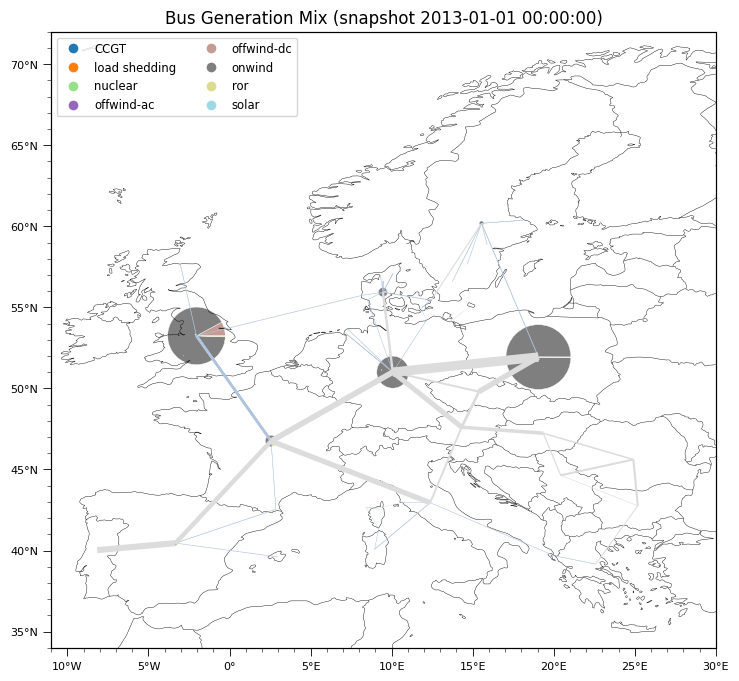

In [46]:
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

if CARTOPY_AVAILABLE and not n.generators_t.p.empty:
    gen_flow = n.generators_t.p.loc[snap]
    if gen_flow.abs().sum() == 0:
        print("Generator dispatch is zero at this snapshot; check that you're loading the solved network.")
    else:
        meta = n.generators[["bus", "carrier"]]
        df = pd.DataFrame({"p": gen_flow, "bus": meta.bus, "carrier": meta.carrier})
        pies = df.pivot_table(index="bus", columns="carrier", values="p", aggfunc="sum").fillna(0.0)
        pies = pies[pies.sum(axis=1) > 0]
        if len(pies) == 0:
            print("No generation at snapshot to plot pies.")
        else:
            from matplotlib.patches import Wedge

            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
            # tweak multipliers below to scale AC line and DC link thickness in the background map
            line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)
            link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)
            try:
                n.plot(
                    ax=ax,
                    boundaries=(-11, 30, 34, 72),
                    bus_sizes=0.0,
                    line_widths=line_widths,
                    line_colors="gainsboro",
                    link_widths=link_widths,
                    link_colors="lightsteelblue",
                    branch_components={"Line", "Link"},
                )
            except Exception as exc:
                print("n.plot failed; falling back to plain coastlines:", exc)
                ax.set_extent((-11, 30, 34, 72))
                ax.coastlines()
            carriers = pies.columns.tolist()
            colors = plt.cm.tab20(np.linspace(0, 1, len(carriers)))
            color_map = dict(zip(carriers, colors))
            max_total = pies.sum(axis=1).max()
            r_scale = 2.0 / max_total if max_total > 0 else 0.0  # adjust numerator for larger/smaller pies
            for bus, row in pies.iterrows():
                x = n.buses.loc[bus, "x"]
                y = n.buses.loc[bus, "y"]
                total = row.sum()
                if total <= 0:
                    continue
                start = 0.0
                radius = total * r_scale
                for carrier in carriers:
                    val = row.get(carrier, 0.0)
                    if val <= 0:
                        continue
                    angle = 360 * val / total
                    wedge = Wedge((x, y), radius, start, start + angle, facecolor=color_map[carrier], edgecolor="white", linewidth=0.3)
                    ax.add_patch(wedge)
                    start += angle
            legend_handles = [
                plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map[c], label=c, markersize=8)
                for c in carriers
            ]
            ax.legend(handles=legend_handles, loc="upper left", fontsize="small", ncol=2, frameon=True)

            ax.set_axis_on()
            for spine in ax.spines.values():
                spine.set_visible(True)
            ax.set_xlim(-11, 30)
            ax.set_ylim(34, 72)

            major_xticks = np.arange(-10, 31, 5)
            major_yticks = np.arange(35, 73, 5)
            ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
            ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(LongitudeFormatter())
            ax.yaxis.set_major_formatter(LatitudeFormatter())
            ax.tick_params(axis="both", which="major", labelsize=8, length=6, width=0.6, direction="out")
            ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
            ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))
            ax.tick_params(axis="both", which="minor", length=3, width=0.4, direction="out")

            ax.set_title(f"Bus Generation Mix (snapshot {snap})")
            plt.show()
elif not CARTOPY_AVAILABLE:
    print("Cartopy not available; skipping pie map.")
else:
    print("No generator dispatch stored in this network file. Sync the solved network (elec_s_140...).")

## Line loading distribution

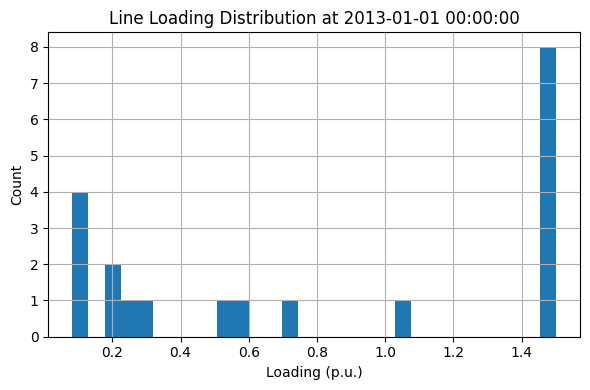

In [47]:
if 'p0' in n.lines_t:
    loading = (n.lines_t.p0.loc[snap].abs() / n.lines.s_nom).fillna(0.0)
    plt.figure(figsize=(6, 4))
    loading.clip(upper=1.5).hist(bins=30)
    plt.title(f'Line Loading Distribution at {snap}')
    plt.xlabel('Loading (p.u.)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('Line flow results missing in network file.')

## Marginal prices

In [48]:
if 'marginal_price' in n.buses_t:
    prices = n.buses_t.marginal_price.loc[snap].dropna().sort_values(ascending=False)
    price_table = pd.DataFrame({
        'bus': prices.index,
        'price_EUR_per_MWh': prices.values
    })
    price_table.head(10)
else:
    print('No marginal prices stored in buses_t.')

## Objective value and cost breakdown

In [49]:
if hasattr(n, 'objective'):
    total_obj = float(n.objective / 1e6)
    print(f'Total objective: {total_obj:.2f} million EUR')
else:
    print('Objective attribute missing; using cost components only.')

gen_nom = n.generators.get('p_nom_opt', n.generators['p_nom'])
capex_gen = (gen_nom * n.generators.get('capital_cost', 0.0)).sum()

if len(n.stores):
    store_nom = n.stores.get('e_nom_opt', n.stores['e_nom'])
    capex_store = (store_nom * n.stores.get('capital_cost', 0.0)).sum()
else:
    capex_store = 0.0

if 'capital_cost' in n.lines.columns:
    line_nom = n.lines.get('s_nom_opt', n.lines['s_nom'])
    capex_lines = (line_nom * n.lines['capital_cost']).sum()
else:
    capex_lines = 0.0

operating_costs = (n.objective - (capex_gen + capex_store + capex_lines)) if hasattr(n, 'objective') else float('nan')

pd.Series({
    'generator_capex_EUR': capex_gen,
    'storage_capex_EUR': capex_store,
    'line_capex_EUR': capex_lines,
    'operating_costs_EUR': operating_costs
}) / 1e6

Total objective: 1389480.62 million EUR


generator_capex_EUR    1.727775e+05
storage_capex_EUR      1.849467e+04
line_capex_EUR         1.296571e+04
operating_costs_EUR    1.185243e+06
dtype: float64

In [50]:
co2_constraints = n.global_constraints[n.global_constraints.index.str.contains('co2', case=False)]
if co2_constraints.empty:
    display(n.global_constraints)
    print("No CO2-labeled global constraint found; above shows all available constraints.")
else:
    display(co2_constraints[[c for c in co2_constraints.columns if c not in {'carrier_attribute'}]])
    if 'sense' in co2_constraints.columns and 'constant' in co2_constraints.columns:
        for name, row in co2_constraints.iterrows():
            print(f"Constraint {name}: {row['sense']} {row['constant']:.2f} tCO2")

carrier_emissions = n.carriers.get('co2_emissions')
if carrier_emissions is None or carrier_emissions.isnull().all():
    print("Carrier sheet lacks co2_emissions values; cannot compute realised emissions.")
else:
    def component_emissions(power_df, component_df):
        if power_df is None or power_df.empty:
            return 0.0
        factors = component_df['carrier'].map(carrier_emissions).fillna(0.0)
        return power_df.mul(factors, axis=1).sum().sum()

    gen_emissions = component_emissions(n.generators_t.p, n.generators)
    link_emissions = component_emissions(getattr(n.links_t, 'p0', None), n.links)
    store_emissions = component_emissions(getattr(n.stores_t, 'p', None), n.stores)
    total_operational_co2 = gen_emissions + link_emissions + store_emissions
    print(f"Realised operational CO2: {total_operational_co2:.2f} tCO2")


,sense,constant,mu,type,investment_period
GlobalConstraint,,,,,
CO2Limit,<=,77500000.0,-26.929093,primary_energy,NaN


Constraint CO2Limit: <= 77500000.00 tCO2
Realised operational CO2: 625.04 tCO2


## Notes
- **Data source**: Set `RESULT_PATH` to any solved PyPSA-Earth network file (`.nc` format)
- **Configuration**: Extend to longer horizons or additional carriers via config files
- **Extensions**: Add carrier breakdowns, regional analysis, or storage flows as needed
- **Interpretation**: Check objective value, cost breakdown, and margin prices for model validation

In [51]:
import pypsa
n_diag = pypsa.Network(RESULT_PATH)
assert n_diag.buses[['x','y']].notna().all().all()

       'CZ0 0 lignite', 'DE0 0 coal', 'DE0 0 geothermal', 'DE0 0 lignite',
       'DE0 0 oil', 'DE27 0 coal', 'DK0 0 biomass', 'DK0 0 coal', 'DK0 0 oil',
       'DK12 0 coal', 'DK12 0 oil', 'ES0 0 biomass', 'ES0 0 coal',
       'ES0 0 lignite', 'ES0 0 oil', 'ES9 0 coal', 'ES9 0 lignite',
       'ES9 0 oil', 'FR0 0 coal', 'FR0 0 geothermal', 'FR0 0 lignite',
       'FR0 0 oil', 'FR7 0 biomass', 'FR7 0 coal', 'FR7 0 oil',
       'GB3 0 biomass', 'GB3 0 coal', 'GB3 0 oil', 'GB32 0 biomass',
       'GB32 0 oil', 'GB4 0 biomass', 'GR0 0 coal', 'GR0 0 lignite',
       'GR0 0 oil', 'GR11 0 oil', 'GR40 0 oil', 'HU0 0 geothermal',
       'HU0 0 lignite', 'HU0 0 oil', 'IT0 0 coal', 'IT0 0 geothermal',
       'IT0 0 oil', 'IT6 0 coal', 'IT6 0 oil', 'PL0 0 biomass', 'PL0 0 coal',
       'PL0 0 lignite', 'PL0 0 oil', 'PT0 0 biomass', 'PT0 0 coal',
       'PT0 0 oil', 'PT47 0 oil', 'RO0 0 coal', 'RO0 0 lignite', 'RO0 0 oil',
       'RS0 0 lignite', 'RS0 0 oil', 'SE12 0 biomass', 'SE12 0 oil',
      

In [54]:
line_widths_raw = n_diag.lines.s_nom_opt.fillna(n_diag.lines.s_nom)
print("Lines with zero rating:", (line_widths_raw <= 0).sum(), " / ", len(line_widths_raw))
print("Bus coords missing:", n_diag.buses[['x','y']].isna().any(axis=1).sum())
if hasattr(n_diag, 'loads_t') and 'p_set' in n_diag.loads_t:
    peak_loads = n_diag.loads_t.p_set.max()  # per-load max over snapshots
    load_per_bus = peak_loads.groupby(n_diag.loads.loc[peak_loads.index, 'bus']).sum()
    print("Peak load per bus summary (MW):")
    print(load_per_bus.describe())
else:
    print("Load time series missing; confirm you're opening the solved network export.")

Lines with zero rating: 0  /  20
Bus coords missing: 0
Peak load per bus summary (MW):
count       49.000000
mean      8476.309035
std      18703.601316
min          0.672660
25%         51.662841
50%        739.914378
75%       6555.674460
max      86083.301677
dtype: float64


In [55]:
# Debug: Check actual bus naming
print("Sample bus names:")
print(n.buses.index.tolist()[:30])
print("\nBus carriers:")
print(n.buses['carrier'].value_counts())


Sample bus names:
['AT0 0', 'AT31 0', 'BG0 0', 'CZ0 0', 'CZ2 0', 'DE0 0', 'DE20 0', 'DE21 0', 'DE22 0', 'DE27 0', 'DE28 0', 'DE29 0', 'DE30 0', 'DK0 0', 'DK12 0', 'DK13 0', 'DK14 0', 'DK15 0', 'DK16 0', 'DK17 0', 'DK18 0', 'DK19 0', 'DK26 0', 'DK41 0', 'DK42 0', 'DK43 0', 'DK44 0', 'DK45 0', 'DK46 0', 'ES0 0']

Bus carriers:
carrier
H2         70
battery    70
AC         36
DC         34
Name: count, dtype: int64


In [56]:
# ✅ CLUSTERING VERIFICATION (the critical test - did focus_weights work?)
import re

# Extract country from bus name - format is like "AT0 0", "IT0 0 H2", "SE46 0"
# Count ONLY AC and DC buses (electricity clusters)
ac_dc_buses = n.buses[n.buses['carrier'].isin(['AC', 'DC'])]
buses_df = pd.DataFrame({'bus': ac_dc_buses.index})
buses_df['country'] = buses_df['bus'].apply(lambda x: re.match(r'([A-Z]{2})\d+', str(x)).group(1) if re.match(r'([A-Z]{2})', str(x)) else 'UNK')
nodes_per_country = buses_df.groupby('country')['bus'].count().sort_values(ascending=False)

print(f"\n{'='*70}")
print(f"CLUSTERING VERIFICATION")
print(f"{'='*70}")
print(f"\nNetwork Summary:")
print(f"  Total buses: {len(n.buses)}")
print(f"  AC/DC buses (electricity network): {len(ac_dc_buses)}")
print(f"  H2 buses: {(n.buses['carrier'] == 'H2').sum()}")
print(f"  Battery buses: {(n.buses['carrier'] == 'battery').sum()}")
print(f"  Total AC/DC clusters: {len(nodes_per_country)}")
print(f"  Generators: {len(n.generators)}")
print(f"  Snapshots: {len(n.snapshots)}")

print(f"\nNodes per country (AC+DC only):")
print(nodes_per_country)

# Check critical countries
se_nodes = nodes_per_country.get('SE', 0)
dk_nodes = nodes_per_country.get('DK', 0)

print(f"\n{'='*70}")
print(f"CRITICAL CHECK:")
print(f"{'='*70}")
if se_nodes == 1 and dk_nodes == 1:
    print(f"✅ CLUSTERING FIXED!")
    print(f"   Sweden:  {se_nodes} node (expected: 1) ✓")
    print(f"   Denmark: {dk_nodes} node (expected: 1) ✓")
    print(f"\nThe focus_weights fix worked! Clustering is correct.")
else:
    print(f"❌ CLUSTERING STILL BROKEN:")
    print(f"   Sweden:  {se_nodes} nodes (expected: 1)")
    print(f"   Denmark: {dk_nodes} nodes (expected: 1)")
    print(f"\n⚠️  The issue persists. The scenario-core-electricity.yaml config")
    print(f"   may not have been properly loaded, keeping H2/battery buses.")
    print(f"\nNeed to investigate config file merging on ARC.")


CLUSTERING VERIFICATION

Network Summary:
  Total buses: 210
  AC/DC buses (electricity network): 70
  H2 buses: 70
  Battery buses: 70
  Total AC/DC clusters: 16
  Generators: 410
  Snapshots: 8

Nodes per country (AC+DC only):
country
DK    16
DE     8
FR     7
SE     7
GB     6
GR     5
IT     4
ES     3
AT     2
CZ     2
PL     2
PT     2
RO     2
RS     2
BG     1
HU     1
Name: bus, dtype: int64

CRITICAL CHECK:
❌ CLUSTERING STILL BROKEN:
   Sweden:  7 nodes (expected: 1)
   Denmark: 16 nodes (expected: 1)

⚠️  The issue persists. The scenario-core-electricity.yaml config
   may not have been properly loaded, keeping H2/battery buses.

Need to investigate config file merging on ARC.


## Root Cause: Why Is Clustering Still Broken?

The focus_weights fix **moved** the parameter to the correct location (`cluster_options:`), but it still didn't work. This suggests one of:

1. **PyPSA-Earth version mismatch** — The v0.8.0 codebase may use a different read pattern
2. **Config merging issue** — Snakemake's config file merging may have a priority problem
3. **distribute_clusters parameter required** — The `distribute_clusters: ["load"]` may not be working as expected
4. **Deeper PyPSA-Earth bug** — The clustering algorithm itself may have an issue

Need to investigate the actual PyPSA-Earth code to see how it reads focus_weights and implements clustering.